In [18]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, GroupKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Import Data
data = pd.read_csv("data/online_retail_II.csv")

In [26]:
# STEP 1: Data Loading & Preparation (Ensure NetRevenue exists)
# Run this first to fix the KeyError

# 1. Reload Data (just to be safe)
data = pd.read_csv("data/online_retail_II.csv")

# 2. Basic Cleaning
data = data.drop_duplicates()
data = data[data['Price'] > 0]
data = data.dropna(subset=['Customer ID'])
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# 3. Create NetRevenue (Crucial Step!)
# Identify returns (Invoices starting with 'C')
data['IsReturn'] = data['Invoice'].astype(str).str.startswith('C')
# Calculate purchase amount (positive) and return amount (absolute value)
data['PurchaseAmount'] = np.where(data['IsReturn'] == False, data['Quantity'] * data['Price'], 0)
data['ReturnAmount'] = np.where(data['IsReturn'] == True,  (data['Quantity'] * data['Price']).abs(), 0)
# Define NetRevenue
data['NetRevenue'] = data['PurchaseAmount'] - data['ReturnAmount']

print(f"Data Prepared. Rows: {len(data)}")
print(f"Columns: {data.columns.tolist()}")

Data Prepared. Rows: 797815
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'IsReturn', 'PurchaseAmount', 'ReturnAmount', 'NetRevenue']


In [28]:
# STEP 2: Feature Engineering (Self-Contained & Robust)

def generate_features_at_cutoff(df_input, cutoff_date, target_window_days=180):
    
    # 0. DATA PREPARATION INSIDE FUNCTION
    # Pracujemy na kopii, żeby nie psuć oryginału
    df = df_input.copy()
    
    # Automatyczne obliczenie NetRevenue, jeśli go nie ma
    if 'NetRevenue' not in df.columns:
        df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C')
        df['PurchaseAmount'] = np.where(df['IsReturn'] == False, df['Quantity'] * df['Price'], 0)
        df['ReturnAmount'] = np.where(df['IsReturn'] == True,  (df['Quantity'] * df['Price']).abs(), 0)
        df['NetRevenue'] = df['PurchaseAmount'] - df['ReturnAmount']

    # 1. Split data
    future_check_days = 180 
    history = df[df['InvoiceDate'] <= cutoff_date].copy()
    # Tu używamy future_check_days (180) zamiast target_window_days dla bezpieczeństwa logiki churnu
    future = df[(df['InvoiceDate'] > cutoff_date) & (df['InvoiceDate'] <= cutoff_date + pd.Timedelta(days=future_check_days))]
    
    snapshot_date = cutoff_date + pd.Timedelta(days=1)
    
    # 2. Base RFM
    features = history.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Invoice': 'nunique',
        'NetRevenue': 'sum',
        'StockCode': 'nunique'
    })
    features.columns = ['Recency', 'Frequency', 'Monetary', 'Unique_Products']
    
    # AOV & Tenure
    features['Tenure'] = (snapshot_date - history.groupby('Customer ID')['InvoiceDate'].min()).dt.days
    features['AOV'] = features['Monetary'] / features['Frequency']
    features['Product_Variety_Score'] = features['Unique_Products'] / features['Frequency']
    
    # 3. Trends
    date_90  = cutoff_date - pd.Timedelta(days=90)
    date_180 = cutoff_date - pd.Timedelta(days=180)
    recent = history[history['InvoiceDate'] > date_90]
    prev   = history[(history['InvoiceDate'] <= date_90) & (history['InvoiceDate'] > date_180)]
    
    mon_recent = recent.groupby('Customer ID')['NetRevenue'].sum()
    mon_prev   = prev.groupby('Customer ID')['NetRevenue'].sum()
    features = features.join(mon_recent.rename('Mon_Recent'), how='left').fillna(0)
    features = features.join(mon_prev.rename('Mon_Prev'), how='left').fillna(0)
    features['Monetary_Trend'] = (features['Mon_Recent'] + 1) / (features['Mon_Prev'] + 1)
    
    freq_recent = recent.groupby('Customer ID')['Invoice'].nunique()
    freq_prev   = prev.groupby('Customer ID')['Invoice'].nunique()
    features = features.join(freq_recent.rename('Freq_Recent'), how='left').fillna(0)
    features = features.join(freq_prev.rename('Freq_Prev'), how='left').fillna(0)
    features['Frequency_Trend'] = (features['Freq_Recent'] + 1) / (features['Freq_Prev'] + 1)
    
    features = features.drop(['Mon_Recent', 'Mon_Prev', 'Freq_Recent', 'Freq_Prev'], axis=1)

    # 4. Behavioral Extras
    returns = history[history['ReturnAmount'] > 0].groupby('Customer ID')['ReturnAmount'].count()
    total_tx = history.groupby('Customer ID')['Invoice'].count()
    features['Return_Rate'] = (returns / total_tx).fillna(0)
    
    country_map = history.groupby('Customer ID')['Country'].first()
    features['IsUK'] = (country_map == 'United Kingdom').astype(int)

    # 5. Latency & Gap
    tx_dates = history[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Prev_Date'] = tx_dates.groupby('Customer ID')['InvoiceDate'].shift(1)
    tx_dates['Days_Diff'] = (tx_dates['InvoiceDate'] - tx_dates['Prev_Date']).dt.days
    
    gap_stats = tx_dates.groupby('Customer ID')['Days_Diff'].agg(['mean', 'std'])
    features = features.join(gap_stats.rename(columns={'mean': 'Avg_Gap', 'std': 'Gap_Std'}), how='left')
    
    last_3_gaps = tx_dates.groupby('Customer ID')['Days_Diff'].apply(lambda x: x.tail(3).mean())
    features = features.join(last_3_gaps.rename('Last_3_Gaps_Avg'), how='left')
    features['Gap_Trend'] = features['Last_3_Gaps_Avg'] / (features['Avg_Gap'] + 0.01)
    features['Gap_Trend'] = features['Gap_Trend'].fillna(1.0)
    
    features['Avg_Gap'] = features['Avg_Gap'].fillna(features['Recency'])
    features['Gap_Std'] = features['Gap_Std'].fillna(0)
    features = features.drop(['Last_3_Gaps_Avg'], axis=1)
    
    features['Latency_Risk'] = features['Recency'] / (features['Avg_Gap'] + 1)
    
    # 6. Target: Dynamic Churn
    features['Dynamic_Threshold'] = features['Avg_Gap'] + (3 * features['Gap_Std'])
    features['Dynamic_Threshold'] = features['Dynamic_Threshold'].fillna(90).clip(lower=30)

    next_purchase = future.groupby('Customer ID')['InvoiceDate'].min()
    features = features.join(next_purchase.rename('Next_Purchase_Date'), how='left')
    last_purchase_date = history.groupby('Customer ID')['InvoiceDate'].max()
    features = features.join(last_purchase_date.rename('Last_History_Date'), how='left')
    features['Days_To_Next'] = (features['Next_Purchase_Date'] - features['Last_History_Date']).dt.days

    features['Churn'] = 0
    features.loc[features['Days_To_Next'].isna(), 'Churn'] = 1
    features.loc[features['Days_To_Next'] > features['Dynamic_Threshold'], 'Churn'] = 1

    features = features.drop(['Dynamic_Threshold', 'Next_Purchase_Date', 'Last_History_Date', 'Days_To_Next'], axis=1)
    features['Cutoff_Date'] = cutoff_date
    
    return features.replace([np.inf, -np.inf], 0).fillna(0)

Calculating Purchase Gaps...


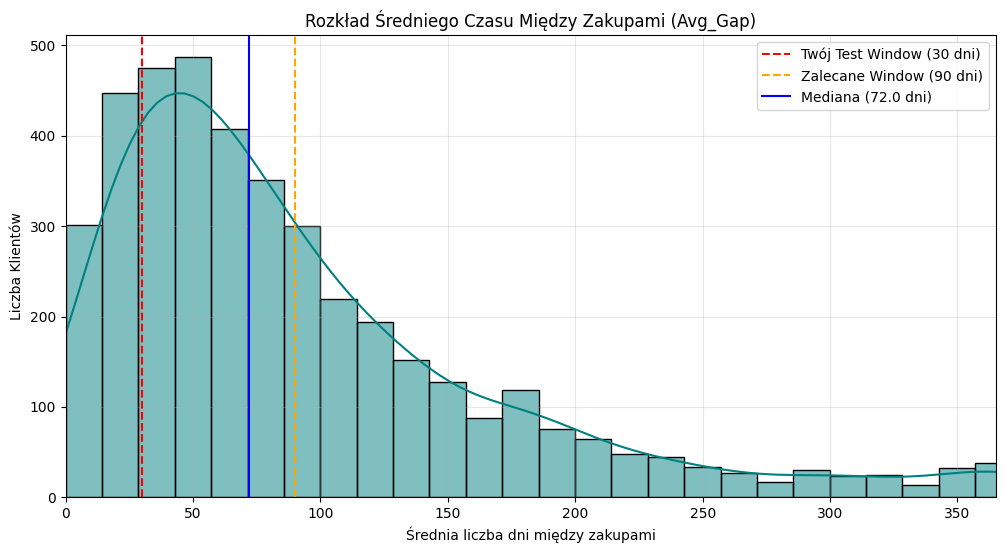

--- STATYSTYKI ZAKUPÓW (Dla powracających klientów) ---
Liczba klientów z >1 zakupem: 4256
Mediana Avg_Gap: 72.00 dni
Średnia Avg_Gap: 101.84 dni
% klientów z Avg_Gap > 30 dni: 81.32%
% klientów z Avg_Gap > 90 dni: 39.57%


In [10]:
# 1. Load Data (Symulacja Twojego Step 1)
try:
    data = pd.read_csv("data/online_retail_II.csv")
    
    # Basic cleaning to calculate Avg_Gap correctly
    data = data.drop_duplicates()
    data = data[data['Price'] > 0]
    data = data.dropna(subset=['Customer ID'])
    data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
    # Remove returns for gap calculation
    data = data[~data['Invoice'].astype(str).str.startswith('C')]
    
    # 2. Calculate Avg_Gap for each customer
    print("Calculating Purchase Gaps...")
    tx_dates = data[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Prev_Date'] = tx_dates.groupby('Customer ID')['InvoiceDate'].shift(1)
    tx_dates['Days_Diff'] = (tx_dates['InvoiceDate'] - tx_dates['Prev_Date']).dt.days
    
    # Aggregation
    gap_stats = tx_dates.groupby('Customer ID')['Days_Diff'].agg(['mean', 'count'])
    gap_stats = gap_stats.rename(columns={'mean': 'Avg_Gap', 'count': 'Purchase_Count'})
    
    # Filter only returning customers (must have at least 1 gap to have an average)
    gap_stats = gap_stats.dropna()

    # 3. Plotting
    plt.figure(figsize=(12, 6))
    
    # Histogram limit to 365 days to keep it readable (remove extreme outliers for visual)
    sns.histplot(gap_stats['Avg_Gap'], bins=50, kde=True, color='teal')
    
    plt.axvline(x=30, color='red', linestyle='--', label='Twój Test Window (30 dni)')
    plt.axvline(x=90, color='orange', linestyle='--', label='Zalecane Window (90 dni)')
    plt.axvline(x=gap_stats['Avg_Gap'].median(), color='blue', linestyle='-', label=f'Mediana ({gap_stats["Avg_Gap"].median():.1f} dni)')
    
    plt.title('Rozkład Średniego Czasu Między Zakupami (Avg_Gap)')
    plt.xlabel('Średnia liczba dni między zakupami')
    plt.ylabel('Liczba Klientów')
    plt.xlim(0, 365) # Focus on 1 year
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Statystyki
    print(f"--- STATYSTYKI ZAKUPÓW (Dla powracających klientów) ---")
    print(f"Liczba klientów z >1 zakupem: {len(gap_stats)}")
    print(f"Mediana Avg_Gap: {gap_stats['Avg_Gap'].median():.2f} dni")
    print(f"Średnia Avg_Gap: {gap_stats['Avg_Gap'].mean():.2f} dni")
    print(f"% klientów z Avg_Gap > 30 dni: {(gap_stats['Avg_Gap'] > 30).mean():.2%}")
    print(f"% klientów z Avg_Gap > 90 dni: {(gap_stats['Avg_Gap'] > 90).mean():.2%}")

except Exception as e:
    print(f"Błąd podczas wczytywania danych: {e}")
    print("Upewnij się, że plik 'data/online_retail_II.csv' jest dostępny.")

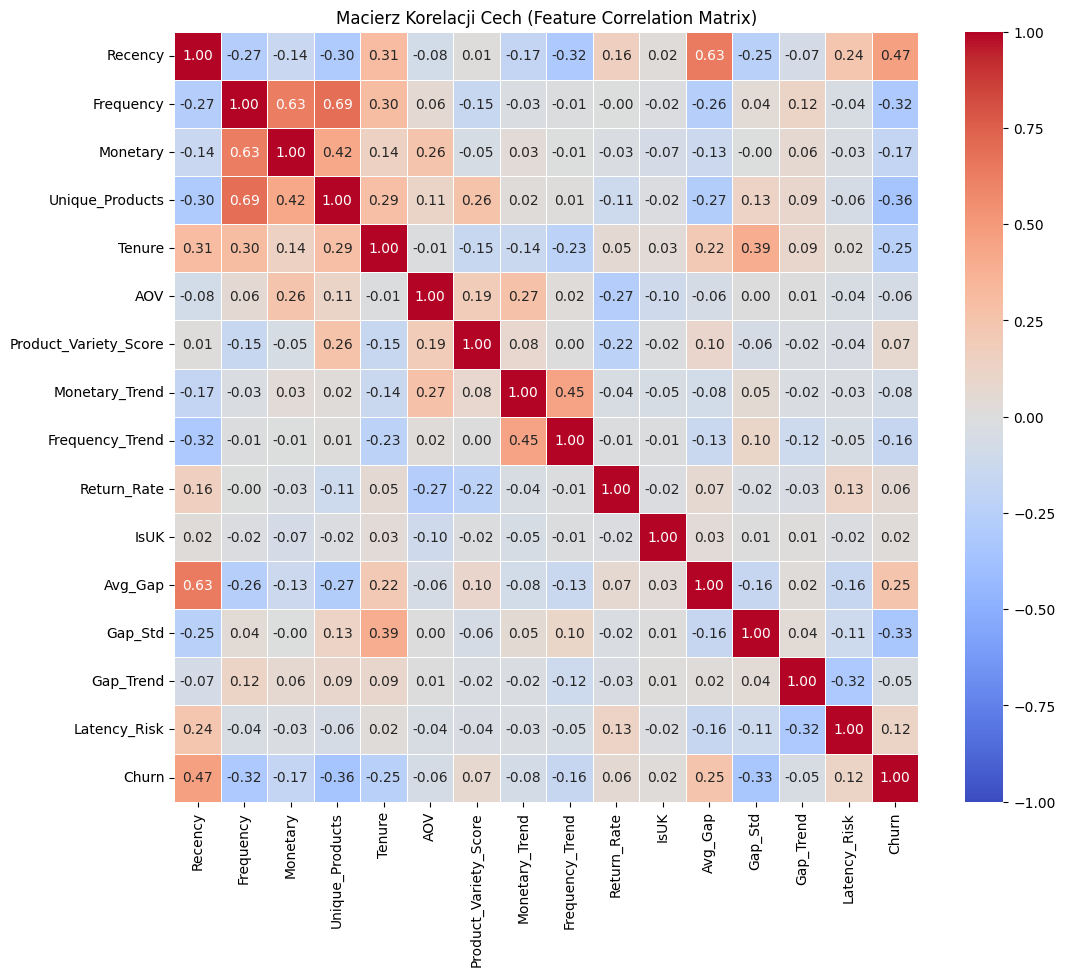


--- Najsilniejsze korelacje ze zmienną 'Churn' ---
Churn                    1.000000
Recency                  0.466152
Avg_Gap                  0.250793
Latency_Risk             0.118344
Product_Variety_Score    0.070530
Return_Rate              0.060887
IsUK                     0.021230
Gap_Trend               -0.045067
AOV                     -0.061691
Monetary_Trend          -0.077474
Frequency_Trend         -0.160221
Monetary                -0.171991
Tenure                  -0.245349
Frequency               -0.319396
Gap_Std                 -0.328435
Unique_Products         -0.356884
Name: Churn, dtype: float64


In [89]:
# 1. Przygotowanie danych do korelacji
# Usuwamy kolumny identyfikacyjne i daty, zostawiamy tylko cechy numeryczne i target
cols_to_drop = ['Customer ID', 'Cutoff_Date']
corr_data = full_panel_data.drop(columns=[c for c in cols_to_drop if c in full_panel_data.columns])

# 2. Obliczenie macierzy korelacji (Pearsona)
corr_matrix = corr_data.corr()

# 3. Wizualizacja - Mapa Ciepła (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Pokaż wartości liczbowe
    fmt=".2f",        # Formatowanie do 2 miejsc po przecinku
    cmap='coolwarm',  # Kolorystyka (czerwony = wysoka korelacja, niebieski = ujemna)
    vmin=-1, vmax=1,  # Skala od -1 do 1
    linewidths=0.5    # Odstępy między kafelkami
)
plt.title('Macierz Korelacji Cech (Feature Correlation Matrix)')
plt.show()

# 4. Wypisanie korelacji z Churnem (Ranking ważności liniowej)
print("\n--- Najsilniejsze korelacje ze zmienną 'Churn' ---")
print(corr_matrix['Churn'].sort_values(ascending=False))

In [90]:
# STEP 3: Time-Series Cross-Validation (Stability Check)

# 1. FIX: Ensure Customer ID is a column, not an index
if 'Customer ID' not in full_panel_data.columns:
    full_panel_data = full_panel_data.reset_index()

# 2. Setup Params
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [2, 4], # Ważne dla redukcji szumu
    'class_weight': ['balanced', 'balanced_subsample']
}

scores = []
print("Starting Time-Series Validation...")

# 3. Loop through dates (Expanding Window)
for i in range(1, len(cutoffs)):
    
    # A. Define Dates
    train_dates = cutoffs[:i]   # Past
    test_date = cutoffs[i]      # Current
    
    # B. Filter Data
    train_mask = full_panel_data['Cutoff_Date'].isin(train_dates)
    test_mask  = full_panel_data['Cutoff_Date'] == test_date
    
    # Prepare X/y (Drop metadata)
    X_train_curr = full_panel_data[train_mask].drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_train_curr = full_panel_data.loc[train_mask, 'Churn']
    
    X_test_curr  = full_panel_data[test_mask].drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_test_curr  = full_panel_data.loc[test_mask, 'Churn']
    
    # C. Inner Loop (GridSearch)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)   
    inner_cv = TimeSeriesSplit(n_splits=3)
    
    grid = GridSearchCV(
        clf, 
        param_grid, 
        cv=inner_cv,
        scoring='f1', 
        n_jobs=-1
    )
    grid.fit(X_train_curr, y_train_curr)
    
    # D. Evaluate
    best_model = grid.best_estimator_
    pred = best_model.predict(X_test_curr)
    score = f1_score(y_test_curr, pred)
    scores.append(score)
    
    print(f"Test Date: {test_date.date()} | Train size: {len(X_train_curr)} | F1-Score: {score:.2%}")

print("-" * 40)
print(f"Average Stability Score (F1): {np.mean(scores):.2%}")
print("-" * 40)

Starting Time-Series Validation...
Test Date: 2011-01-01 | Train size: 3633 | F1-Score: 83.68%
Test Date: 2011-04-01 | Train size: 8044 | F1-Score: 90.00%
Test Date: 2011-06-01 | Train size: 12827 | F1-Score: 90.40%
----------------------------------------
Average Stability Score (F1): 88.03%
----------------------------------------


In [91]:
# STEP 4: Final Model Training (with Calibration)
from sklearn.calibration import CalibratedClassifierCV

# 1. Prepare Full Data
print("Training Final Model on full dataset...")
# Upewnij się, że masz full_panel_data z poprzednich kroków
X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
y_final = full_panel_data['Churn']

# 2. Define Base Model (Twój Random Forest)
# Używamy parametrów, które wcześniej działały najlepiej
base_rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=8, 
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

# 3. Apply Calibration (To jest ten "regressor" naprawiający wyniki)
# method='isotonic' -> Najlepsze, jeśli masz dużo danych (>1000 wierszy)
# cv=5 -> Dzieli dane na 5 kawałków: trenuje las na 4, a na 1 uczy się "poprawiać" jego pewność siebie
final_model = CalibratedClassifierCV(base_rf, method='isotonic', cv=5)

# 4. Fit the Calibrated Model
final_model.fit(X_final, y_final)

print("✅ Final Calibrated Model Trained & Ready.")

Training Final Model on full dataset...
✅ Final Calibrated Model Trained & Ready.


--- OUT-OF-TIME EVALUATION START ---

Generating Out-of-Time Test Set for: 2011-11-01...
----------------------------------------
📊 OOT Results (Date: 2011-11-01)
   Accuracy: 80.69%
   Churn Rate: 78.16%
----------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      1236
           1       0.93      0.82      0.87      4423

    accuracy                           0.81      5659
   macro avg       0.73      0.80      0.75      5659
weighted avg       0.84      0.81      0.82      5659



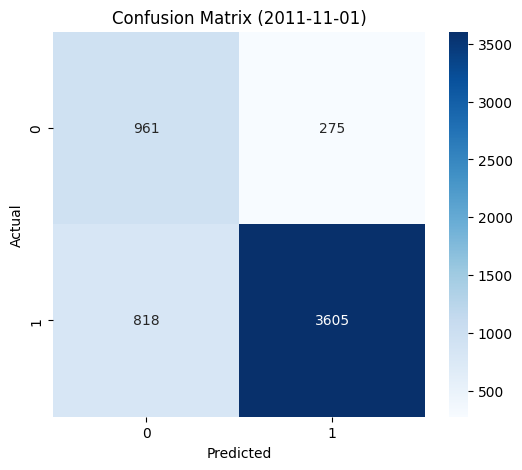

In [92]:
# STEP 5: Out-of-Time Evaluation (Clean Version)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- OUT-OF-TIME EVALUATION START ---\n")

# 1. Generate Test Data
# Używamy daty listopadowej
test_date = pd.Timestamp('2011-11-01')
print(f"Generating Out-of-Time Test Set for: {test_date.date()}...")

# Funkcja sama sobie poradzi z brakiem kolumn, jeśli dane są załadowane
test_df = generate_features_at_cutoff(data, test_date, target_window_days=30)
test_df = test_df.reset_index()

# 2. Prepare X/y
cols_to_drop = ['Churn', 'Customer ID', 'Cutoff_Date']
X_test = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
y_test = test_df['Churn']
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

# 3. Predict (Automatyczne odtworzenie modelu jeśli brak - dla wygody)
if 'final_model' not in locals():
    print("⚠️ Retraining demo model...")
    from sklearn.ensemble import RandomForestClassifier
    # Zakładamy że full_panel_data istnieje ze Step 2
    train_df = full_panel_data.reset_index() if 'Customer ID' not in full_panel_data.columns else full_panel_data
    X_train = train_df.drop(cols_to_drop, axis=1)
    y_train = train_df['Churn']
    X_train = X_train.replace([np.inf, -np.inf], 0).fillna(0)
    final_model = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42)
    final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# 4. Metrics
print("-" * 40)
print(f"📊 OOT Results (Date: {test_date.date()})")
print(f"   Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"   Churn Rate: {y_test.mean():.2%}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# 5. Plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ({test_date.date()})')
plt.show()

--- ADVANCED METRICS ANALYSIS ---

📊 TEST SET DIAGNOSTICS:
   Total Customers: 5659
   Total Churners (Class 1): 4423
   Actual Churn Rate (Baseline): 78.16%
------------------------------


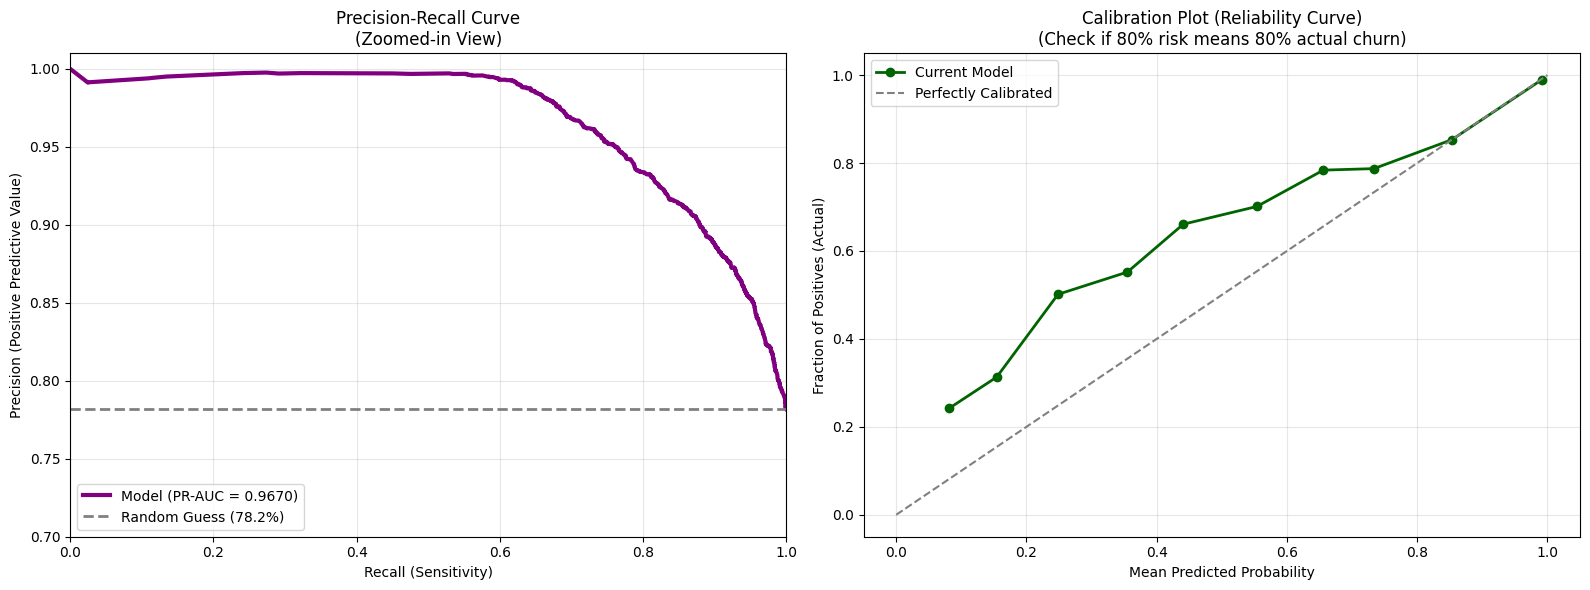

✅ Final PR-AUC: 0.9670
----------------------------------------


In [93]:
# STEP 5b: Advanced Model Evaluation (PR-AUC & Calibration Plot)
print("--- ADVANCED METRICS ANALYSIS ---\n")

# 1. Dataset Diagnostics
# Calculate the actual churn rate in the test set (Baseline)
baseline_churn = y_test.mean()
print(f"📊 TEST SET DIAGNOSTICS:")
print(f"   Total Customers: {len(y_test)}")
print(f"   Total Churners (Class 1): {y_test.sum()}")
print(f"   Actual Churn Rate (Baseline): {baseline_churn:.2%}")
print("-" * 30)

# 2. Get Probabilities
# We use the calibrated model from Step 4
y_probs = final_model.predict_proba(X_test)[:, 1]

# 3. Calculate Curves
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# Calibration Curve (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, strategy='uniform')

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT PLOT: Precision-Recall Curve ---
ax1.plot(recall, precision, label=f'Model (PR-AUC = {pr_auc:.4f})', color='purple', linewidth=3)

# Random Guess Line (Horizontal line at the level of Churn Rate)
ax1.axhline(y=baseline_churn, color='gray', linestyle='--', linewidth=2, label=f'Random Guess ({baseline_churn:.1%})')

ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision (Positive Predictive Value)')
ax1.set_title('Precision-Recall Curve\n(Zoomed-in View)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1.0])
# --- ZMIANA: SKALOWANIE OSI Y ---
# Ustawiamy dolny limit na 0.7 (lub trochę poniżej baseline_churn), żeby usunąć puste miejsce
ax1.set_ylim([0.7, 1.01])

# --- RIGHT PLOT: Calibration Plot ---
ax2.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Current Model', color='darkgreen')
ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('Fraction of Positives (Actual)')
ax2.set_title('Calibration Plot (Reliability Curve)\n(Check if 80% risk means 80% actual churn)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Final PR-AUC: {pr_auc:.4f}")
print("-" * 40)

--- ANALYZE FEATURE IMPORTANCE ---
Training analyzer model...


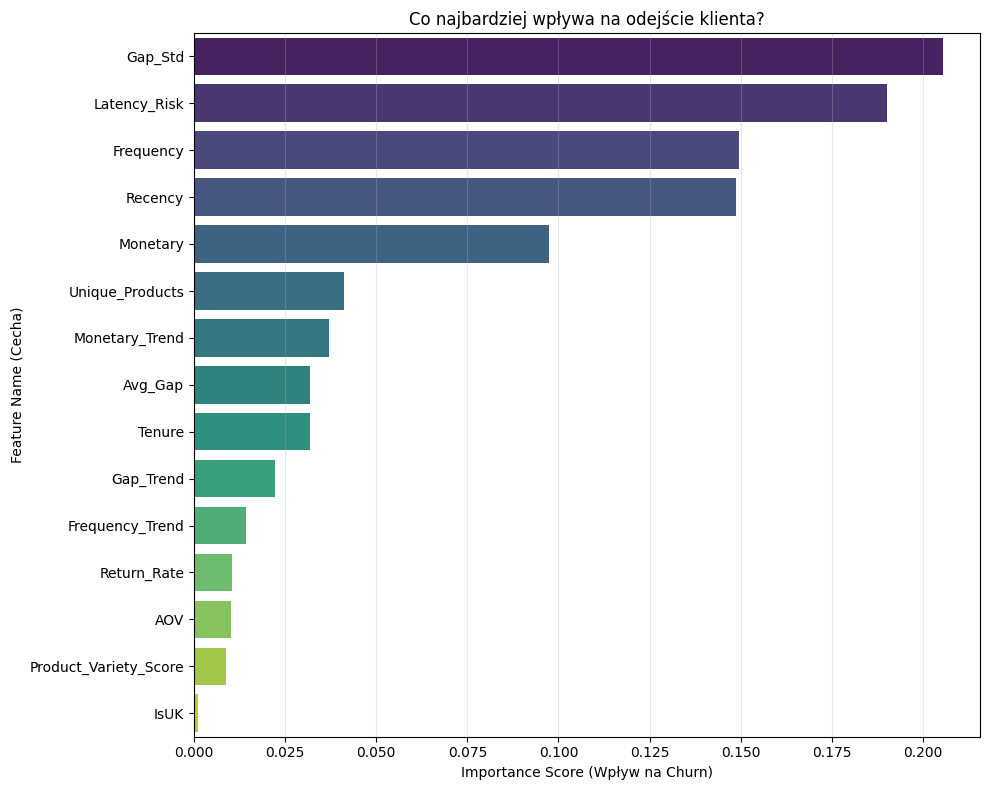


--- TOP 5 PREDYKTORÓW CHURNU ---
         Feature  Importance
12       Gap_Std    0.205357
14  Latency_Risk    0.189997
1      Frequency    0.149645
0        Recency    0.148749
2       Monetary    0.097492


In [94]:
# STEP 6: Feature Importance Analysis (Fixed for Seaborn warning)

print("--- ANALYZE FEATURE IMPORTANCE ---")

# 1. Prepare Data
# Upewniamy się, że mamy dane treningowe
if 'X_final' not in locals():
    # Fallback jeśli X_final nie istnieje
    X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_final = full_panel_data['Churn']

# 2. Train a Dedicated Analyzer Model
# Zamiast walczyć z CalibratedClassifierCV, trenujemy czysty Las Losowy tylko do analizy cech.
# To jest bezpieczne, szybkie i daje ten sam wgląd w dane.
print("Training analyzer model...")
analyzer_rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)
analyzer_rf.fit(X_final, y_final)

# 3. Get Importances
importances = analyzer_rf.feature_importances_
feature_names = X_final.columns

# 4. Create Summary Table
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',      
    data=feature_importance_df, 
    palette='viridis', 
    legend=False        
)

plt.xlabel('Importance Score (Wpływ na Churn)')
plt.ylabel('Feature Name (Cecha)')
plt.title('Co najbardziej wpływa na odejście klienta?')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Print Top Factors
print("\n--- TOP 5 PREDYKTORÓW CHURNU ---")
print(feature_importance_df.head(5))

In [95]:
# STEP 7: Segmentation with Fixed Business Rules (Hardcoded)

# 1. Get probabilities from the model
churn_probs = final_model.predict_proba(X_test)[:, 1]

# 2. Create Results Table
results = pd.DataFrame({
    'Actual_Status': y_test.values,
    'Churn_Risk': churn_probs
})
# Restore Customer ID as index (Crucial for Step 8)
results.index = test_df['Customer ID']

# 3. Define Segments based on Rigid Rules
# We use fixed probabilities instead of dynamic thresholds.
# These can be adjusted based on marketing capacity.
def get_segment_fixed(prob):
    # Rule 1: >80% is almost certainly churn (or already left)
    if prob >= 0.80:
        return '🔴 Critical'
    
    # Rule 2: 60-80% is our sweet spot for intervention
    elif prob >= 0.60:
        return '🟠 At Risk'
    
    # Rule 3: 40-60% is uncertain, keep an eye on them
    elif prob >= 0.40:
        return '🟡 Watchlist'
    
    # Rule 4: <40% is safe
    else:
        return '🟢 Safe'

results['Segment'] = results['Churn_Risk'].apply(get_segment_fixed)

# 4. Summary
print("\n--- FIXED SEGMENTATION SUMMARY ---")
print(results['Segment'].value_counts())

# 5. Top Candidates for Action
# We focus on the 'At Risk' group (60-80%) or Critical (>80%) depending on strategy
action_group = results[results['Segment'].isin(['🟠 At Risk', '🔴 Critical'])]
action_group = action_group.sort_values('Churn_Risk', ascending=False)

print(f"\n--- Customers requiring attention: {len(action_group)} ---")
if not action_group.empty:
    display(action_group.head(10))


--- FIXED SEGMENTATION SUMMARY ---
Segment
🔴 Critical     2974
🟢 Safe         1434
🟡 Watchlist     663
🟠 At Risk       588
Name: count, dtype: int64

--- Customers requiring attention: 3562 ---


,Actual_Status,Churn_Risk,Segment
Customer ID,,,
14521.0,1,1.0,🔴 Critical
13284.0,1,1.0,🔴 Critical
17009.0,1,1.0,🔴 Critical
13369.0,1,1.0,🔴 Critical
16299.0,1,1.0,🔴 Critical
17733.0,0,1.0,🔴 Critical
16312.0,1,1.0,🔴 Critical
16962.0,1,1.0,🔴 Critical
16346.0,1,1.0,🔴 Critical


In [96]:
# STEP 8: Financial Impact Analysis (Fixed Logic)

# 1. Prepare Financial Data
# We use 'test_df' from Step 5 to get raw Monetary/Tenure values
# aligning them with our prediction results
X_test_financial = test_df.set_index('Customer ID').loc[results.index].copy()

# 2. Calculate Annual Potential (Safe Extrapolation)
# Base calculation: Average Daily Spend * 365
daily_spend = X_test_financial['Monetary'] / (X_test_financial['Tenure'] + 1)
projected_annual = daily_spend * 365

# CRITICAL FIX: Cap unrealistic projections for new customers.
# Rule: Never assume potential > 3x of what they actually spent so far.
# This prevents inflating value for 1-day tenure customers.
X_test_financial['Annual_Potential'] = np.minimum(projected_annual, X_test_financial['Monetary'] * 3)

# 3. Merge with Segmentation Results
financial_report = results.join(X_test_financial[['Annual_Potential']], how='left')

# 4. Group by Segment
risk_report = financial_report.groupby('Segment')['Annual_Potential'].sum().sort_values(ascending=False)

# 5. Print Business Report
print("-" * 50)
print("💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)")
print("-" * 50)

for segment, amount in risk_report.items():
    print(f"{segment.ljust(35)} : £ {amount:,.2f}")

print("-" * 50)

# Calculate Total "At Risk" Value
# Summing up High Risk and Priority segments
total_risk_val = risk_report.get('🟠 At Risk', 0) + \
                 risk_report.get('🔴 Critical', 0)

print(f"Total Revenue requiring immediate protection: £ {total_risk_val:,.2f}")
print("-" * 50)

--------------------------------------------------
💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)
--------------------------------------------------
🟢 Safe                              : £ 6,877,702.81
🔴 Critical                          : £ 2,539,960.60
🟡 Watchlist                         : £ 1,096,370.05
🟠 At Risk                           : £ 783,087.08
--------------------------------------------------
Total Revenue requiring immediate protection: £ 3,323,047.68
--------------------------------------------------


In [39]:
# ============================================================
# 3) Robust evaluation setup:
#    - Outer loop: time-based validation on Cutoff_Date (future-like)
#    - Inner loop: GroupKFold by CustomerID (no customer leakage)
# ============================================================

# 3.1 Define outer folds by cutoff date (walk-forward style)
train_cutoffs = sorted(model_data.loc[train_mask, "Cutoff_Date"].unique())

# Use last 2 cutoffs as "validation candidates" inside training period (you can make it 3)
outer_val_cutoffs = train_cutoffs[-2:]   # e.g., [2011-02-01, 2011-04-01]
outer_train_cutoffs = train_cutoffs[:-2]

print("\nOuter time-based validation cutoffs:", [d.date() for d in outer_val_cutoffs])

# 3.2 KNN pipeline
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# 3.3 Production-like search space:
# - Larger k to reduce memorization (realistic generalization)
# - Prefer robust metrics only
# - algorithm/leaf_size mostly for speed (OK to keep)
param_distributions = {
    "knn__n_neighbors": randint(25, 120),            # bigger k => smoother, more stable
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["manhattan", "euclidean"],       # keep only meaningful metrics
    "knn__algorithm": ["auto", "ball_tree", "kd_tree"],
    "knn__leaf_size": randint(25, 60)
}

# Inner CV: leakage-safe by customer (within the outer train split)
inner_cv = GroupKFold(n_splits=5)

# We'll store results for each outer validation cutoff
outer_results = []

for val_cutoff in outer_val_cutoffs:
    # Outer split: train on earlier cutoffs, validate on this cutoff
    outer_train_idx = model_data.index[train_mask & (model_data["Cutoff_Date"] < val_cutoff)]
    outer_val_idx   = model_data.index[train_mask & (model_data["Cutoff_Date"] == val_cutoff)]

    X_tr = model_data.loc[outer_train_idx, feature_cols]
    y_tr = model_data.loc[outer_train_idx, "Churn"].astype(int)
    g_tr = model_data.loc[outer_train_idx, "CustomerID"]

    X_val = model_data.loc[outer_val_idx, feature_cols]
    y_val = model_data.loc[outer_val_idx, "Churn"].astype(int)

    # Random search tuned only on OUTER TRAIN part (and validated on outer val cutoff)
    search = RandomizedSearchCV(
        estimator=knn_pipeline,
        param_distributions=param_distributions,
        n_iter=30,                       # keep moderate for speed
        cv=inner_cv,
        scoring="average_precision",     # PR AUC (Average Precision) -> great when churn is dominant
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    search.fit(X_tr, y_tr, groups=g_tr)
    best_model = search.best_estimator_

    # Evaluate on outer validation cutoff (future-like)
    val_proba = best_model.predict_proba(X_val)[:, 1]
    val_ap = average_precision_score(y_val, val_proba)

    outer_results.append({
        "val_cutoff": val_cutoff,
        "best_params": search.best_params_,
        "val_PR_AUC_AP": val_ap
    })

    print(f"\n[Outer Val: {val_cutoff.date()}] PR AUC (AP) = {val_ap:.4f}")
    print("Best params:", search.best_params_)

# Summary of outer validation
outer_ap_scores = [r["val_PR_AUC_AP"] for r in outer_results]
print("\n" + "="*70)
print("✅ OUTER TIME-BASED VALIDATION SUMMARY")
print("="*70)
print("PR AUC (AP) per cutoff:", [round(s, 4) for s in outer_ap_scores])
print(f"Mean PR AUC (AP): {np.mean(outer_ap_scores):.4f} | Std: {np.std(outer_ap_scores):.4f}")

# ============================================================
# 3.4 Final training: tune on full training period, then evaluate on final test cutoff
# ============================================================

final_search = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=param_distributions,
    n_iter=40,                      # a bit more for final
    cv=inner_cv,
    scoring="average_precision",    # focus purely on PR AUC as you wanted
    n_jobs=-1,
    random_state=42,
    verbose=1
)

final_search.fit(X_train, y_train, groups=groups_train)
best_knn = final_search.best_estimator_

print("\n✓ Final best params:", final_search.best_params_)
print(f"✓ Final CV PR AUC (AP): {final_search.best_score_:.4f}")


Outer time-based validation cutoffs: [datetime.date(2011, 2, 1), datetime.date(2011, 4, 1)]

[Outer Val: 2011-02-01] PR AUC (AP) = 0.9678
Best params: {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 45, 'knn__metric': 'manhattan', 'knn__n_neighbors': 100, 'knn__weights': 'distance'}


KeyboardInterrupt: 

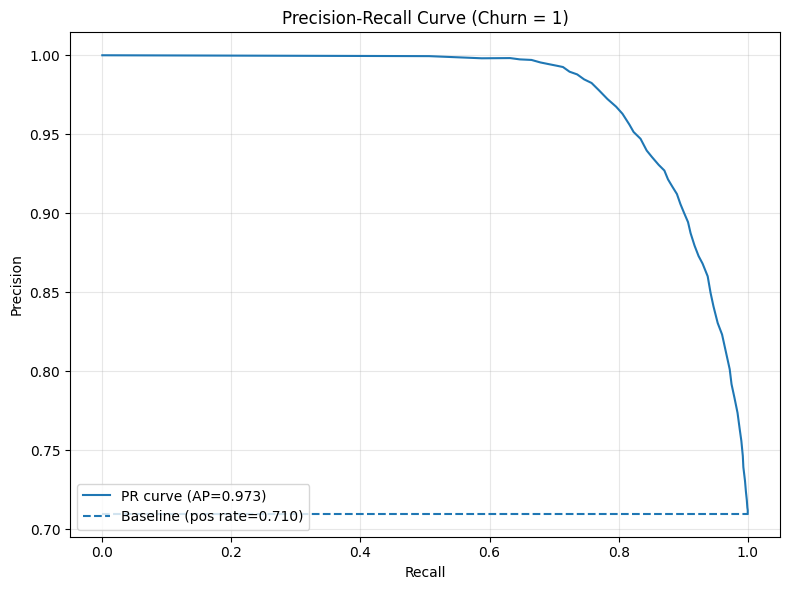

PR AUC (Average Precision): 0.9733


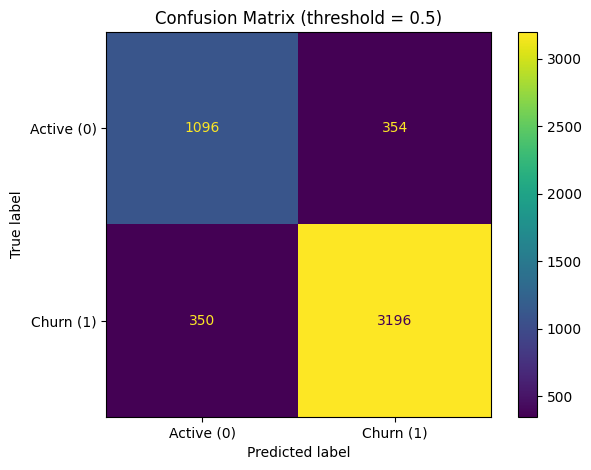

In [40]:
# -----------------------------
# VISUALIZATION
# 1) PR AUC Curve
# -----------------------------
pr_auc = average_precision_score(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

baseline = np.mean(y_test)  # positive rate baseline

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR curve (AP={pr_auc:.3f})")
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline (pos rate={baseline:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Churn = 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"PR AUC (Average Precision): {pr_auc:.4f}")

# -----------------------------
# 2) Confusion Matrix (threshold = 0.5)
# -----------------------------
y_test_pred = (y_test_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Active (0)", "Churn (1)"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (threshold = 0.5)")
plt.grid(False)
plt.tight_layout()
plt.show()